In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from Instruments.SA124B.SA124B import SA124B
# qm
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import program, infinite_loop_, play
from configuration import config, qubit_IF, qubit_LO, IQ_imbalance
from scipy.optimize import minimize

class MixerTuner:
    def __init__(self, carrier, sideBand, power):
        self.sa124B = SA124B(serialNumber = 19184645, mode = 'sweep')
        self.initQM()

        self.carrier = carrier
        self.sideBand = sideBand # pos / neg <=> upper / lower
        self.power = power
        
    def initQM(self):
        qmm = QuantumMachinesManager()
        self.qm = qmm.open_qm(config)
        with program() as hello_qua:
            with infinite_loop_():
                play("CW", "qubit")
        self.job = self.qm.execute(hello_qua)

    def step1CoarseSweep(self, I=0, Q=0, gain=0, phase=0):
        self.qm.set_dc_offset_by_qe("qubit", "I", float(I))
        self.qm.set_dc_offset_by_qe("qubit", "Q", float(Q))
        self.qm.set_mixer_correction("mixer_qubit", qubit_IF, qubit_LO, IQ_imbalance(gain, phase))
        freqs, amps = self.sa124B.initSweep(self.carrier, self.sideBand*10, 100, self.power)
        plt.figure()
        plt.plot(freqs, amps)

    def minimize(self, centers, spans, callback, amps, numIters, numGrids, shrink):
        spans = np.array(spans)
        def minimizeIter(centers_, spans_):
            x = np.linspace(centers_[0]-spans_[0]/2, centers_[0]+spans_[0]/2, numGrids[0])
            y = np.linspace(centers_[1]-spans_[1]/2, centers_[1]+spans_[1]/2, numGrids[1])
            power = np.zeros(numGrids)
            for i, xi in enumerate(x):
                for j, yj in enumerate(y):
                    callback(xi, yj)
                    power[i, j] = self.sa124B.getSweepSingle(len(amps))
            if numGrids[0] == 1:
                plt.plot(y, power[0, :])
                plt.show()
            elif numGrids[1] == 1:
                plt.plot(x, power[:, 0])
                plt.show()
            else:
                fig = go.Figure( data=[go.Surface(z=power, x=x, y=y)] )
                fig.show()
            ind = np.unravel_index(np.argmin(power, axis=None), power.shape)
            minx, miny = x[ind[0]], y[ind[1]]
            return minx, miny
        for i in range(numIters):
            print('iter, centers, spans:', i, centers, spans)
            centers = minimizeIter(centers, spans)
            spans = spans * shrink**(i+1)
        print('final centers:', centers)
        return centers
      
    def step2CarrierLeakage(self, centers, spans, numIters, numGrids, shrink):
        print('step2CarrierLeakage')
        _, amps = self.sa124B.initSweepSingle(center=self.carrier, power=self.power)
        def callback(I, Q):
            self.qm.set_dc_offset_by_qe("qubit", "I", float(I))
            self.qm.set_dc_offset_by_qe("qubit", "Q", float(Q))
        return self.minimize(centers, spans, callback, amps, numIters, numGrids, shrink)
    
    def step3IqImbalance(self, centers, spans, numIters, numGrids, shrink):
        print('step3IqImbalance')
        _, amps = self.sa124B.initSweepSingle(center=self.carrier+self.sideBand, power=self.power)
        def callback(gain, phase):
            self.qm.set_mixer_correction("mixer_qubit", qubit_IF, qubit_LO, IQ_imbalance(gain, phase))
        return self.minimize(centers, spans, callback, amps, numIters, numGrids, shrink)
    

In [2]:
mixerTuner = MixerTuner(carrier = 6e9, sideBand = 50e6, power = 0)

2021-01-15 13:29:58,344 - qm - INFO - Performing health check
2021-01-15 13:29:58,348 - qm - INFO - Health check passed
2021-01-15 13:29:58,655 - qm - INFO - Flags: 
2021-01-15 13:29:58,655 - qm - INFO - Executing high level program


@SA124B.initSweep: resolution= 250000.0


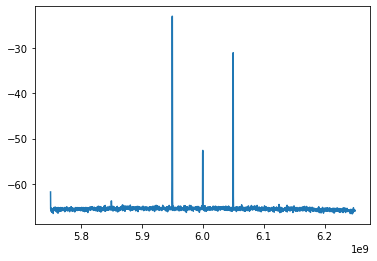

In [3]:
mixerTuner.step1CoarseSweep()

step2CarrierLeakage
@SA124B.initSweep: resolution= 250000.0
iter, centers, spans: 0 [0, 0] [0.2 0.2]


iter, centers, spans: 1 (0.0, 0.0) [0.1 0.1]


iter, centers, spans: 2 (0.0, 0.0) [0.025 0.025]


iter, centers, spans: 3 (0.0, -0.005000000000000001) [0.003125 0.003125]


final centers: (-0.00031250000000000006, -0.004375)
@SA124B.initSweep: resolution= 250000.0


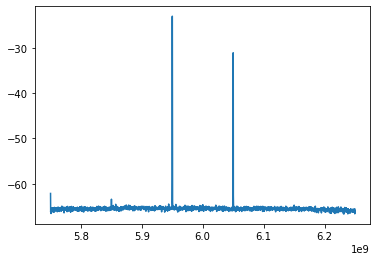

In [4]:
Imin, Qmin = mixerTuner.step2CarrierLeakage(centers=[0, 0], spans=[0.2, 0.2], numIters=4, numGrids=[11, 11], shrink=0.5)
mixerTuner.step1CoarseSweep(I=Imin, Q=Qmin, gain=0, phase=0)

step3IqImbalance
@SA124B.initSweep: resolution= 250000.0
iter, centers, spans: 0 [0, 0] [0.2 0.2]


iter, centers, spans: 1 (-0.020000000000000004, 0.1) [0.18 0.18]


iter, centers, spans: 2 (-0.020000000000000004, 0.19) [0.1458 0.1458]


iter, centers, spans: 3 (-0.005420000000000008, 0.2629) [0.1062882 0.1062882]


iter, centers, spans: 4 (-0.005420000000000008, 0.31604410000000005) [0.06973569 0.06973569]


iter, centers, spans: 5 (-0.012393568802000009, 0.343938375208) [0.04117823 0.04117823]


iter, centers, spans: 6 (-0.008275746160107029, 0.343938375208) [0.0218838 0.0218838]


iter, centers, spans: 7 (-0.010464125942737278, 0.3461267549906303) [0.01046695 0.01046695]


iter, centers, spans: 8 (-0.010464125942737278, 0.3461267549906303) [0.00450568 0.00450568]


iter, centers, spans: 9 (-0.010013557951838494, 0.3456761869997315) [0.00174559 0.00174559]


final centers: (-0.010188117223200248, 0.34602530554245503)
@SA124B.initSweep: resolution= 250000.0


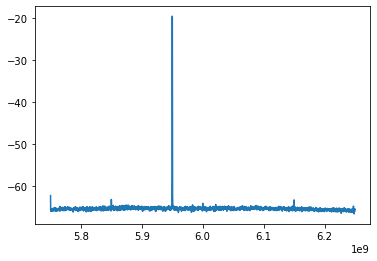

In [5]:
gmin, pmin = mixerTuner.step3IqImbalance(centers=[0, 0], spans=[0.2, 0.2], numIters=10, numGrids=[11, 11], shrink=0.9)
mixerTuner.step1CoarseSweep(I=Imin, Q=Qmin, gain=gmin, phase=pmin)

In [6]:
mixerTuner.sa124B.stop()

('success', 0)

```python
results:

- channels 1, 2: cw = 0.3
    - IQ final centers: (0.01593749999999999, -0.005312500000000001)
    - gain, phase final centers: (-0.025000016106655396, 0.3386585083616496)
- channels 3, 4: cw = 0.3
    - IQ final centers: (0.009999999999999995, -0.008750000000000003)
    - gain, phase final centers: (0.02153621448045734, 0.35205362852657557)
- channels 5, 6: cw = 0.2
    - IQ final centers: (0.008124999999999995, -0.022812500000000003)
    - gain, phase final centers: (0.18426518494587707, 0.39080206877419243)
- channels 7, 8: cw = 0.2
    - IQ final centers: (0.0037500000000000007, -0.006562500000000003)
    - gain, phase final centers: (0.09298324113900173, 0.35795467851316987)
- channels 9, 10: cw = 0.2
    - IQ final centers: (-0.00031250000000000006, -0.004375)
    - gain, phase final centers: (-0.010188117223200248, 0.34602530554245503)
```